In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display
from sympy.interactive import init_session
init_session()
import sympy as sp
import numpy as np

IPython console for SymPy 0.7.6 (Python 2.7.6-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://www.sympy.org


In [2]:
class hamiltonian_system_1D:
    def __init__(self, x, p, H):
        self.H = H
        self.x = x
        self.p = p
        return None
    def xrhs(self):
        return self.H.diff(self.p)
    def prhs(self):
        return -self.H.diff(self.x)

In [3]:
q = sp.Symbol('q')
p = sp.Symbol('p')
h = hamiltonian_system_1D(q, p, p**2/2 - sp.cos(q))

In [4]:
h.xrhs()

In [5]:
h.prhs()

In [6]:
def Euler(rhs, dt = 0.5, N = 8, x0 = None):
    x = np.zeros((N+1,) + x0.shape,
                 dtype = x0.dtype)
    x[0] = x0
    for t in range(N):
        x[t+1] = x[t] + dt*rhs(x[t])
    return x

def cRK(rhs, dt = 0.5, N = 8, x0 = None):
    x = np.zeros((N+1,) + x0.shape,
                 dtype = x0.dtype)
    x[0] = x0
    for t in range(N):
        k1 = rhs(x[t])
        k2 = rhs(x[t] + 0.5*dt*k1)
        k3 = rhs(x[t] + 0.5*dt*k2)
        k4 = rhs(x[t] + dt*k3)
        x[t+1] = x[t] + dt*(k1 + 2*(k2 + k3) + k4)/6
    return x

def get_evdt(
        initial_condition,
        h0, N0, ndivisions,
        method,
        rhs):
    epsilon = []
    tstep = [h0]
    sol = []

    N = N0
    sol.append(method(rhs,
                      dt = tstep[-1],
                      N = N,
                      x0 = initial_condition))
    for n in range(1, ndivisions + 1):
        tstep.append(h0*2.**(-n))
        N = N*2
        sol.append(method(rhs,
                          dt = tstep[-1],
                          N = N,
                          x0 = initial_condition))
        epsilon.append(sol[-1][-1] - sol[-2][-1])

    return (np.array(tstep[:len(tstep)-1]),
            np.abs(epsilon))

In [7]:
xrhs = sp.utilities.lambdify((q, p), h.xrhs(), modules = 'numpy')
prhs = sp.utilities.lambdify((q, p), h.prhs(), modules = 'numpy')

def pendulum_rhs(point):
    return np.array([xrhs(*tuple(point))*np.ones(point.shape[1:]),
                     prhs(*tuple(point))*np.ones(point.shape[1:])])

In [8]:
dt, err = get_evdt(
        np.array([np.zeros(10),
                  np.linspace(0, 1.9, 10)]),
        1., 4, 5,
        Euler,
        pendulum_rhs)
dt4, err4 = get_evdt(
        np.array([np.zeros(10),
                  np.linspace(0, 1.9, 10)]),
        1., 4, 4,
        cRK,
        pendulum_rhs)

<IPython.core.display.Javascript object>


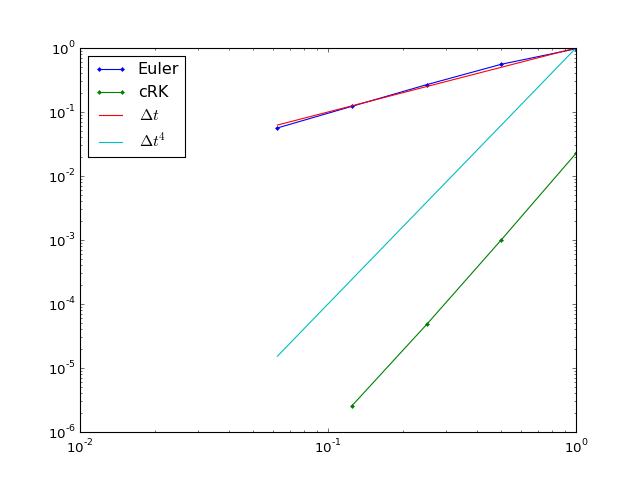

In [9]:
a = plt.figure().add_subplot(111)

a.plot(dt, np.average(err, axis = (1, 2)),
        marker = '.', label = 'Euler')
a.plot(dt4, np.average(err4, axis = (1, 2)),
        marker = '.', label = 'cRK')
a.plot(dt, dt, label = '$\Delta t$')
a.plot(dt, (dt**4), label = '$\Delta t^4$')
a.set_xscale('log')
a.set_yscale('log')
a.legend(loc = 'best')

In [10]:
initial_condition = np.array([np.zeros(10),
                              np.linspace(0, 1.9, 10)])

x = cRK(pendulum_rhs,
        dt = 0.125,
        N = 3*2**4,
        x0 = initial_condition)


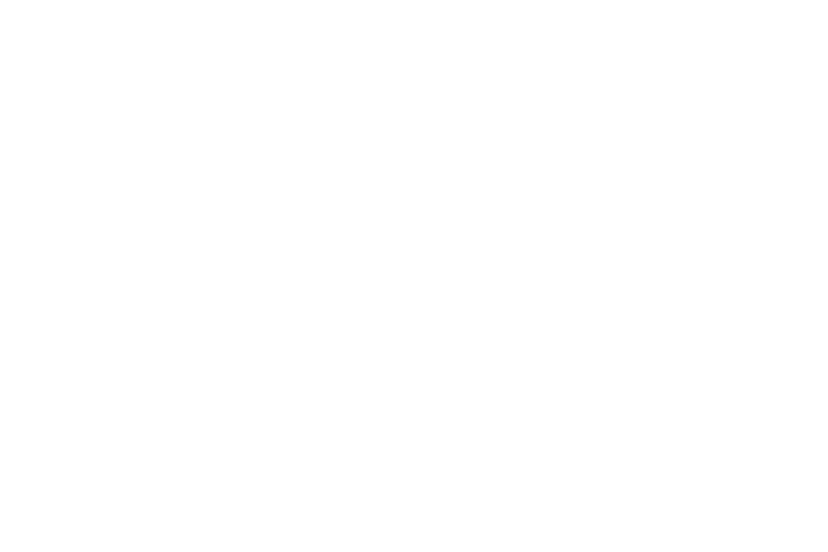

In [11]:
a = plt.figure(figsize = (6, 4)).add_subplot(111)
a.plot(x[:, 0, :], x[:, 1, :])


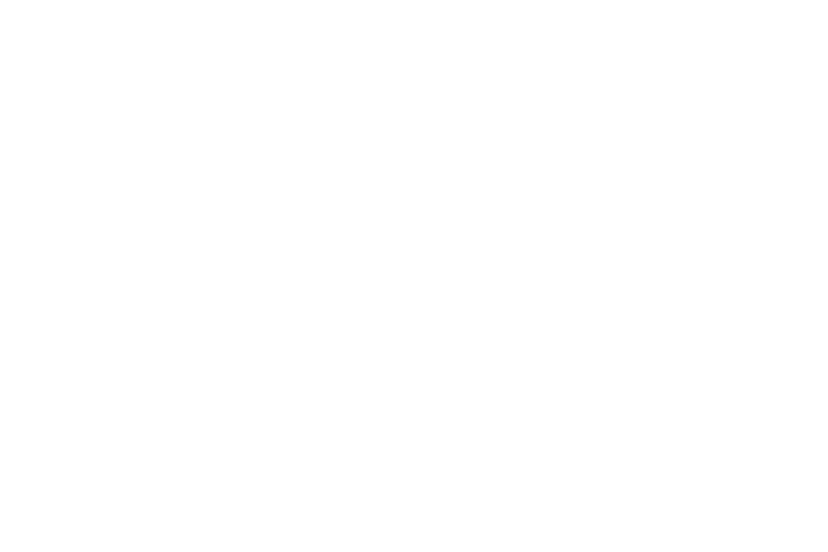

In [12]:
# code from http://nbviewer.ipython.org/gist/aburgm/7ecac8c7835f4c5816b3


plt.close('all')
fig = plt.figure(figsize=(6,4))
a = fig.add_subplot(111)
a.set_xlim(-3, 3)
a.set_ylim(-2, 2)
lines = a.plot(x[:, 0, :], x[:, 1, :])

def init():
    for l in lines:
        l.set_data([], [])
    return lines,

def animate(i):
    for l in range(len(lines)):
        lines[l].set_data(x[:i%x.shape[0], 0,l], x[:i%x.shape[0], 1,l])
    return lines,

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func = init,
                               frames = x.shape[0],
                               interval = 100,
                               repeat_delay = 1000,
                               blit = False)
plt.show()


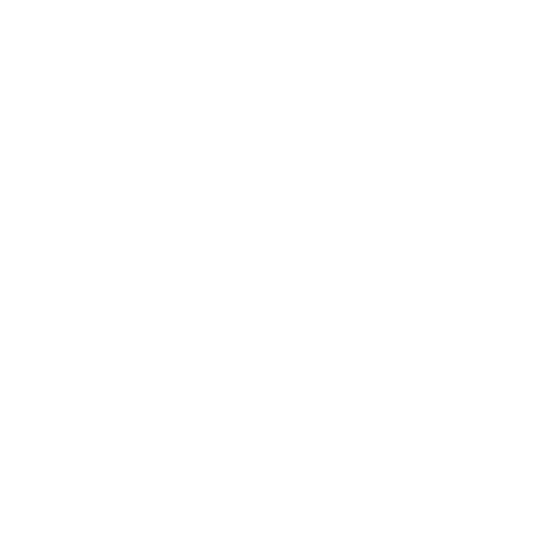

In [13]:
plt.close('all')

x = cRK(pendulum_rhs,
        dt = 0.125,
        N = 3*2**6,
        x0 = initial_condition)

fig = plt.figure(figsize=(4,4))
a = fig.add_subplot(111)
a.set_xlim(-1.5, 1.5)
a.set_ylim(-1.5, 1.5)

xx =  np.sin(x[0, 0, -1])
yy = -np.cos(x[0, 0, -1])
line = a.plot([0., xx],
              [0., yy])
point = a.scatter([xx], [yy])

tt = np.linspace(0, 2*np.pi, 128)
a.plot(np.cos(tt),
       np.sin(tt),
       dashes = (2, 2),
       color = (0, 0, 0))

def init1():
    return line, point

def animate1(i):
    xx =  np.sin(x[i, 0, -1])
    yy = -np.cos(x[i, 0, -1])
    line[0].set_data([0., xx], [0., yy])
    point.set_offsets([[xx, yy]])
    return line, point

anim = animation.FuncAnimation(fig,
                               animate1,
                               init_func = init1,
                               frames = x.shape[0],
                               interval = 100,
                               repeat_delay = 1000,
                               blit = True)
plt.show()

In [14]:
help(point.set_offsets)

Help on method set_offsets in module matplotlib.collections:

set_offsets(self, offsets) method of matplotlib.collections.PathCollection instance
    Set the offsets for the collection.  *offsets* can be a scalar
    or a sequence.
    
    ACCEPTS: float or sequence of floats



In [15]:
class hamiltonian_system_1D:
    def __init__(self, x, p, H):
        self.H = H
        self.x = x
        self.p = p
        self.xrhs = sp.utilities.lambdify(
                (q, p),
                self.H.diff(self.p),
                modules = 'numpy')
        self.prhs = sp.utilities.lambdify(
                (q, p),
                -self.H.diff(self.x),
                modules = 'numpy')
        return None
    def rhs(self, point):
        return np.array(
                [self.xrhs(*tuple(point))*np.ones(point.shape[1:]),
                 self.prhs(*tuple(point))*np.ones(point.shape[1:])])


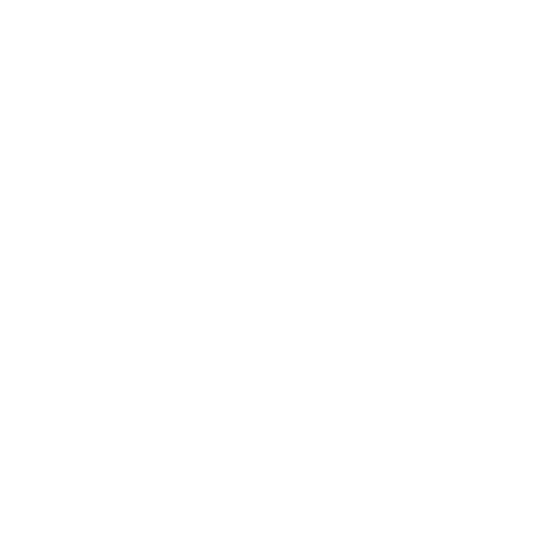

In [16]:
q = sp.Symbol('q')
p = sp.Symbol('p')
pendulum = hamiltonian_system_1D(q, p, p**2/2 - sp.cos(q))

initial_condition = np.array([np.zeros(10),
                              np.linspace(0, 1.9, 10)])
x = cRK(pendulum.rhs,
        dt = 0.125,
        N = 3*2**6,
        x0 = initial_condition)

plt.close('all')

fig = plt.figure(figsize=(4,4))
a = fig.add_subplot(111)
a.set_xlim(-1.5, 1.5)
a.set_ylim(-1.5, 1.5)

xx =  np.sin(x[0, 0, -1])
yy = -np.cos(x[0, 0, -1])
line = a.plot([0., xx],
              [0., yy])
point = a.scatter([xx], [yy])

tt = np.linspace(0, 2*np.pi, 128)
a.plot(np.cos(tt),
       np.sin(tt),
       dashes = (2, 2),
       color = (0, 0, 0))

def init1():
    return line, point

def animate1(i):
    xx =  np.sin(x[i, 0, -1])
    yy = -np.cos(x[i, 0, -1])
    line[0].set_data([0., xx], [0., yy])
    point.set_offsets([[xx, yy]])
    return line, point

anim = animation.FuncAnimation(fig,
                               animate1,
                               init_func = init1,
                               frames = x.shape[0],
                               interval = 100,
                               repeat_delay = 1000,
                               blit = True)
plt.show()

In [17]:
class hamiltonian_system:
    def __init__(self, x, p, H):
        assert(len(x) == len(p))
        self.H = H
        self.x = x
        self.p = p
        self.degrees_of_freedom = len(self.x)
        self.rhs = ([sp.utilities.lambdify(tuple(self.x)+tuple(self.p),
                                           self.H.diff(self.p[i]),
                                           modules = 'numpy')
                     for i in range(self.degrees_of_freedom)] +
                    [sp.utilities.lambdify(tuple(self.x)+tuple(self.p),
                                           -self.H.diff(self.x[i]),
                                           modules = 'numpy')
                     for i in range(self.degrees_of_freedom)])
        return None
    def numpy_rhs(self, point):
        return np.array([self.rhs[i](*tuple(point)) * np.ones(point.shape[1:])
                         for i in range(2*self.degrees_of_freedom)])


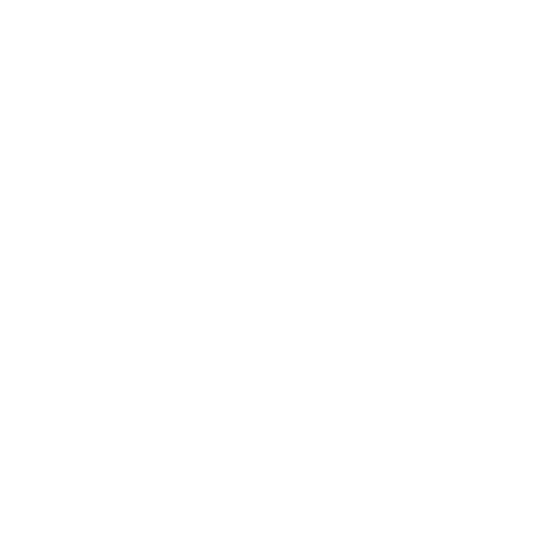

In [18]:
q = sp.Symbol('q')
p = sp.Symbol('p')
pendulum = hamiltonian_system([q], [p], p**2/2 - sp.cos(q))

initial_condition = np.array([np.zeros(10),
                              np.linspace(0, 1.9, 10)])
x = cRK(pendulum.numpy_rhs,
        dt = 0.125,
        N = 3*2**6,
        x0 = initial_condition)

plt.close('all')

fig = plt.figure(figsize=(4,4))
a = fig.add_subplot(111)
a.set_xlim(-1.5, 1.5)
a.set_ylim(-1.5, 1.5)

xx =  np.sin(x[0, 0, -1])
yy = -np.cos(x[0, 0, -1])
line = a.plot([0., xx],
              [0., yy])
point = a.scatter([xx], [yy])

tt = np.linspace(0, 2*np.pi, 128)
a.plot(np.cos(tt),
       np.sin(tt),
       dashes = (2, 2),
       color = (0, 0, 0))

def init1():
    return line, point

def animate1(i):
    xx =  np.sin(x[i, 0, -1])
    yy = -np.cos(x[i, 0, -1])
    line[0].set_data([0., xx], [0., yy])
    point.set_offsets([[xx, yy]])
    return line, point

anim = animation.FuncAnimation(fig,
                               animate1,
                               init_func = init1,
                               frames = x.shape[0],
                               interval = 100,
                               repeat_delay = 1000,
                               blit = True)
plt.show()

In [19]:
plt.close('all')
x = sp.Symbol('x')
y = sp.Symbol('y')
p = sp.Symbol('p')
q = sp.Symbol('q')

l1 = 1.0
l2 = 1.5
m1 = 1.0
m2 = 0.25

H = (- l1*(m1 + m2)*sp.cos(x)
     - l2*m2*sp.cos(y)
     - ((l2**2 * m2 * p**2 -
         2*l1*l2*m2*sp.cos(x - y)*p*q +
         l1**2*(m1+m2)*q**2) /
        (l1**2 * l2**2 * m2 * (-2*m1 - m2 + m2*sp.cos(2*(x - y))))))
double_pendulum = hamiltonian_system([x, y], [p, q], H)

initial_condition = np.array([0., 0., 1., 1.])
sol = cRK(double_pendulum.numpy_rhs,
          dt = 2.**(-4),
          N = 2**8,
          x0 = initial_condition)


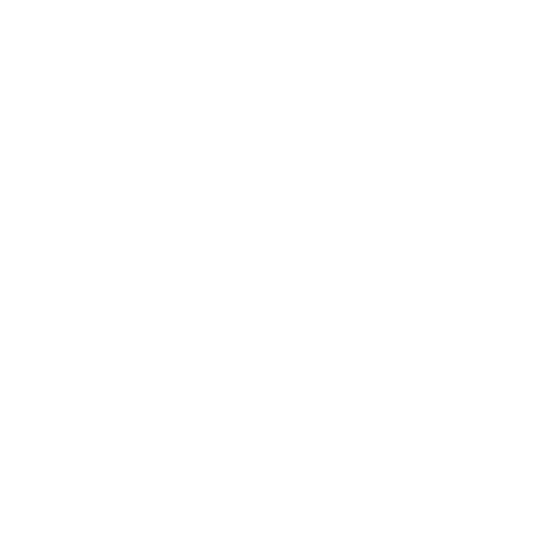

In [20]:
plt.close('all')

fig = plt.figure(figsize=(4,4))
a = fig.add_subplot(111)
a.set_xlim(-(l1+l2)*1.1, (l1+l2)*1.1)
a.set_ylim(-(l1+l2)*1.1, (l1+l2)*1.1)

xx1 =  l1*np.sin(sol[0, 0])
yy1 = -l1*np.cos(sol[0, 0])
xx2 = xx1 + l2*np.sin(sol[0, 1])
yy2 = yy1 - l2*np.cos(sol[0, 1])
line1 = a.plot([0., xx1, xx2],
               [0., yy1, yy2])
point1 = a.scatter([xx1, xx2], [yy1, yy2])

tt = np.linspace(0, 2*np.pi, 128)
a.plot(np.cos(tt),
       np.sin(tt),
       dashes = (2, 2),
       color = (0, 0, 0))

def init1():
    return line1, point1

def animate1(i):
    xx1 =  l1*np.sin(sol[i, 0])
    yy1 = -l1*np.cos(sol[i, 0])
    xx2 = xx1 + l2*np.sin(sol[i, 1])
    yy2 = yy1 - l2*np.cos(sol[i, 1])
    line1[0].set_data([0., xx1, xx2], [0., yy1, yy2])
    point1.set_offsets([[xx1, yy1], [xx2, yy2]])
    return line1, point1

anim = animation.FuncAnimation(fig,
                               animate1,
                               init_func = init1,
                               frames = sol.shape[0],
                               interval = 100,
                               repeat_delay = 1000,
                               blit = True)
plt.show()


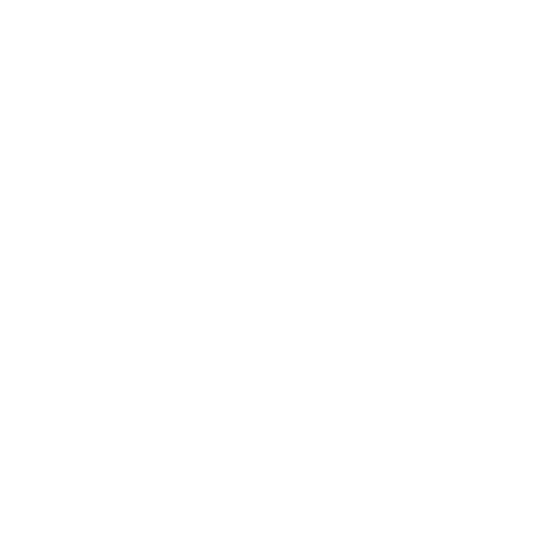

In [21]:
xx1 =  l1*np.sin(sol[:, 0])
yy1 = -l1*np.cos(sol[:, 0])
xx2 = xx1 + l2*np.sin(sol[:, 1])
yy2 = yy1 - l2*np.cos(sol[:, 1])

plt.close('all')

fig = plt.figure(figsize=(4,4))
a = fig.add_subplot(111)
a.set_xlim(-(l1+l2)*1.1, (l1+l2)*1.1)
a.set_ylim(-(l1+l2)*1.1, (l1+l2)*1.1)

line1 = a.plot([0., xx1[0], xx2[0]],
               [0., yy1[0], yy2[0]])
point1 = a.scatter([xx1[0], xx2[0]], [yy1[0], yy2[0]])

tt = np.linspace(0, 2*np.pi, 128)
a.plot(np.cos(tt),
       np.sin(tt),
       dashes = (2, 2),
       color = (0, 0, 0))

def init1():
    return line1, point1

def animate1(i):
    line1[0].set_data([0., xx1[i], xx2[i]],
                      [0., yy1[i], yy2[i]])
    point1.set_offsets([[xx1[i], yy1[i]],
                        [xx2[i], yy2[i]]])
    return line1, point1

anim = animation.FuncAnimation(fig,
                               animate1,
                               init_func = init1,
                               frames = sol.shape[0],
                               interval = 40,
                               repeat_delay = 1000,
                               blit = True)
plt.show()


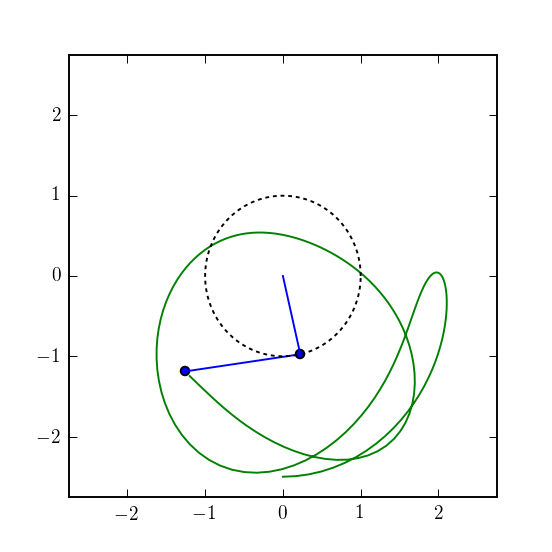

In [22]:
xx1 =  l1*np.sin(sol[:, 0])
yy1 = -l1*np.cos(sol[:, 0])
xx2 = xx1 + l2*np.sin(sol[:, 1])
yy2 = yy1 - l2*np.cos(sol[:, 1])

plt.close('all')

fig = plt.figure(figsize=(4,4))
a = fig.add_subplot(111)
a.set_xlim(-(l1+l2)*1.1, (l1+l2)*1.1)
a.set_ylim(-(l1+l2)*1.1, (l1+l2)*1.1)

bars = a.plot([0., xx1[0], xx2[0]],
              [0., yy1[0], yy2[0]])
points = a.scatter([xx1[0], xx2[0]], [yy1[0], yy2[0]])
traj2 = a.plot([], [])

tt = np.linspace(0, 2*np.pi, 128)
a.plot(np.cos(tt),
       np.sin(tt),
       dashes = (2, 2),
       color = (0, 0, 0))

def init1():
    return bars, points, traj2

def animate1(i):
    bars[0].set_data([0., xx1[i], xx2[i]],
                      [0., yy1[i], yy2[i]])
    points.set_offsets([[xx1[i], yy1[i]],
                        [xx2[i], yy2[i]]])
    traj2[0].set_data(xx2[:i+1], yy2[:i+1])
    return bars, points, traj2

anim = animation.FuncAnimation(fig,
                               animate1,
                               init_func = init1,
                               frames = sol.shape[0],
                               interval = 40,
                               repeat_delay = 1000,
                               blit = True)
plt.show()